In [1]:
!pip install catboost category_encoders optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd

import re
import string

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download("wordnet")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier, Pool

import optuna

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...


## Download data

In [3]:
### posts data

posts_info = pd.read_sql(
    """
      SELECT *
      FROM public.post_text_df
    """,

    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [4]:
### users data merge with users actions data

feed_data = pd.read_sql(
    """
      SELECT
        cast(extract(hour from timestamp) as int) as hour,
        cast(extract(month from timestamp) as int) as month,
        timestamp,
        public.feed_data.user_id,
        post_id,
        gender,
        age,
        country,
        city,
        exp_group,
        os,
        source,
        target

      FROM public.feed_data

      JOIN public.user_data
      ON public.feed_data.user_id = public.user_data.user_id

      WHERE action = 'view'

      LIMIT 5000000
    """,

    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,hour,month,timestamp,user_id,post_id,gender,age,country,city,exp_group,os,source,target
0,8,10,2021-10-01 08:52:12,78393,754,1,21,Russia,Kotelnich,3,Android,ads,0
1,8,10,2021-10-01 08:53:08,78393,1313,1,21,Russia,Kotelnich,3,Android,ads,0
2,8,10,2021-10-01 08:53:19,78393,1622,1,21,Russia,Kotelnich,3,Android,ads,0
3,8,10,2021-10-01 08:54:14,78393,986,1,21,Russia,Kotelnich,3,Android,ads,0
4,8,10,2021-10-01 08:55:32,78393,6967,1,21,Russia,Kotelnich,3,Android,ads,0


## Feature Engineering

## using TF-IDF for creating new features

In [5]:
wnl = nltk.stem.WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

tfidf

TfidfVectorizer(preprocessor=<function preprocessing at 0x7a592426f130>,
                stop_words='english')

In [6]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

In [7]:
tfidf_data.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
### generate new features based on Tf-Idf

posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

### apply clustering approach for new Tf-Idf data, using PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)
# get belonging to clusters
dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.499989,0.443140,0.387001,0.465934,0.502674,0.440277,0.139529,0.479471,0.579920,0.442499,0.434291,0.443599,0.686100,0.529847,0.545772
1,0.370710,0.292831,0.187079,0.328437,0.375004,0.292158,0.262385,0.341224,0.343587,0.287798,0.153240,0.298428,0.573883,0.413151,0.443351
2,0.394799,0.314747,0.218257,0.355533,0.388804,0.313574,0.138104,0.361296,0.537640,0.332318,0.333030,0.330388,0.517783,0.432553,0.479662
3,0.321236,0.265587,0.145318,0.300268,0.353021,0.257687,0.238255,0.320806,0.496261,0.280322,0.264374,0.294518,0.434866,0.388594,0.445845
4,0.295166,0.180472,0.069171,0.233197,0.296210,0.162461,0.298586,0.259646,0.461764,0.241168,0.220732,0.226349,0.498049,0.344086,0.401265


In [9]:
posts_info = pd.concat((posts_info,dists_df), axis=1)
posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,6,0.499989,0.443140,0.387001,...,0.440277,0.139529,0.479471,0.579920,0.442499,0.434291,0.443599,0.686100,0.529847,0.545772
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,10,0.370710,0.292831,0.187079,...,0.292158,0.262385,0.341224,0.343587,0.287798,0.153240,0.298428,0.573883,0.413151,0.443351
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000275,6,0.394799,0.314747,0.218257,...,0.313574,0.138104,0.361296,0.537640,0.332318,0.333030,0.330388,0.517783,0.432553,0.479662
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,2,0.321236,0.265587,0.145318,...,0.257687,0.238255,0.320806,0.496261,0.280322,0.264374,0.294518,0.434866,0.388594,0.445845
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,2,0.295166,0.180472,0.069171,...,0.162461,0.298586,0.259646,0.461764,0.241168,0.220732,0.226349,0.498049,0.344086,0.401265


In [10]:
## saving features to the database
posts_info.to_sql(
   "posts_info_features_table",
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",
    schema="public",
    if_exists='replace'
)

23

In [11]:
## clean up the variables

del wnl
del tfidf
del pca
del PCA
del KMeans
del preprocessing

del tfidf_data
del centered
del pca_decomp
del kmeans
del dists_columns
del dists_df

import gc

gc.collect()

2059

In [12]:
### merge dataframes into one

df = pd.merge(
    feed_data,
    posts_info.drop('text', axis=1),
    on='post_id',
    how='left'
)

del feed_data
del posts_info

df = df.set_index(['user_id', 'post_id'])

df.head(50)

hour  month           timestamp  gender  age country  \
user_id post_id                                                         
78393   754         8     10 2021-10-01 08:52:12       1   21  Russia   
        1313        8     10 2021-10-01 08:53:08       1   21  Russia   
        1622        8     10 2021-10-01 08:53:19       1   21  Russia   
        986         8     10 2021-10-01 08:54:14       1   21  Russia   
        6967        8     10 2021-10-01 08:55:32       1   21  Russia   
        1627        8     10 2021-10-01 08:56:12       1   21  Russia   
        2213        8     10 2021-10-01 08:56:34       1   21  Russia   
        6361        8     10 2021-10-01 08:59:23       1   21  Russia   
        1074        9     10 2021-10-01 09:00:53       1   21  Russia   
        1226        9     10 2021-10-01 09:01:05       1   21  Russia   
        6077        9     10 2021-10-01 09:03:14       1   21  Russia   
        3541        9     10 2021-10-01 09:04:37       1   21  Russia   
        5969        9     10 2021-10-01 09:06:00       1   21  Russia   
        3715        9     10 2021-10-01 09:08:09       1   21  Russia   
        644         9     10 2021-10-01 09:09:37       1   21  Russia   
        5210        9     10 2021-10-01 09:11:37       1   21  Russia   
        5333        9     10 2021-10-01 09:13:26       1   21  Russia   
        5309        9     10 2021-10-01 09:15:08       1   21  Russia   
        4631        9     10 2021-10-01 09:15:22       1   21  Russia   
        5593        9     10 2021-10-01 09:16:00       1   21  Russia   
        2287        9     10 2021-10-01 09:16:21       1   21  Russia   
        5975        9     10 2021-10-01 09:18:01       1   21  Russia   
        7052        9     10 2021-10-01 09:19:38       1   21  Russia   
        4268        9     10 2021-10-01 09:20:53       1   21  Russia   
        201         9     10 2021-10-01 09:23:16       1   21  Russia   
        5682        9     10 2021-10-01 09:26:12       1   21  Russia   
        1541       13     10 2021-10-07 13:18:52       1   21  Russia   
        1051       13     10 2021-10-07 13:20:00       1   21  Russia   
        1602       13     10 2021-10-07 13:21:20       1   21  Russia   
        3017       13     10 2021-10-07 13:21:49       1   21  Russia   
        2671       13     10 2021-10-07 13:22:26       1   21  Russia   
        3106       13     10 2021-10-07 13:25:22       1   21  Russia   
        6504       13     10 2021-10-07 13:26:27       1   21  Russia   
        1651       13     10 2021-10-07 13:28:19       1   21  Russia   
        5692       13     10 2021-10-07 13:30:53       1   21  Russia   
        1012       13     10 2021-10-07 13:31:33       1   21  Russia   
        4941       13     10 2021-10-07 13:32:57       1   21  Russia   
        4359       13     10 2021-10-07 13:35:21       1   21  Russia   
        201        13     10 2021-10-07 13:37:31       1   21  Russia   
        6380       13     10 2021-10-07 13:38:42       1   21  Russia   
        1932       13     10 2021-10-07 13:39:58       1   21  Russia   
        6716       13     10 2021-10-07 13:41:07       1   21  Russia   
        1447       13     10 2021-10-07 13:41:24       1   21  Russia   
        2          13     10 2021-10-07 13:44:14       1   21  Russia   
        6624       13     10 2021-10-07 13:44:40       1   21  Russia   
        3734       13     10 2021-10-07 13:47:07       1   21  Russia   
        6538       13     10 2021-10-07 13:49:28       1   21  Russia   
        5480       13     10 2021-10-07 13:49:55       1   21  Russia   
        2425       13     10 2021-10-07 13:50:05       1   21  Russia   
        4463       13     10 2021-10-07 13:51:19       1   21  Russia   

                      city  exp_group       os source  ...  \
user_id post_id                                        ...   
78393   754      Kotelnich          3  Android    ads  ...   
        1313     Kotelnich        

In [13]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:43:31'), Timestamp('2021-10-01 06:01:40'))

In [14]:
### split the data into train and test by date 2021-12-15

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((4179183,), (820817,))

In [15]:
del df

In [16]:
# columns order

cols_ = [
    'topic', 'TotalTfIdf', 'MaxTfIdf', 'MeanTfIdf', 'TextCluster',
    'DistanceTo1thCluster', 'DistanceTo2thCluster', 'DistanceTo3thCluster',
    'DistanceTo4thCluster', 'DistanceTo5thCluster', 'DistanceTo6thCluster',
    'DistanceTo7thCluster', 'DistanceTo8thCluster', 'DistanceTo9thCluster',
    'DistanceTo10thCluster', 'DistanceTo11thCluster',
    'DistanceTo12thCluster', 'DistanceTo13thCluster',
    'DistanceTo14thCluster', 'DistanceTo15thCluster', 'gender', 'age',
    'country', 'city', 'exp_group', 'os', 'source', 'hour', 'month'
]

X_train = X_train[cols_]
X_test = X_test[cols_]

del cols_

In [17]:
object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

## Modeling

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def optimize_catboost(trial):
    params = {
            'objective': 'Logloss',
            'task_type': 'GPU',
            'iterations': trial.suggest_int('iterations', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'depth': trial.suggest_int('depth', 2, 8),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 8.0),
        }

    # create a model with parameteres
    model = CatBoostClassifier(**params, random_seed=42, cat_features=object_cols, verbose=0)

    # cross-validation
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', verbose=0).mean()

    return score

# CatBoost Optuna
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(optimize_catboost, n_trials=5)
best_params_optimize_catboost = study_catboost.best_params

[I 2024-12-06 12:53:42,806] A new study created in memory with name: no-name-6ab1c597-fcc7-495b-96e0-624f9d3cb9c9
[I 2024-12-06 13:16:54,691] Trial 0 finished with value: 0.6931850065690119 and parameters: {'iterations': 346, 'learning_rate': 0.049843949843121446, 'depth': 8, 'l2_leaf_reg': 5.585105434991802}. Best is trial 0 with value: 0.6931850065690119.
[I 2024-12-06 13:20:25,914] Trial 1 finished with value: 0.6901855881048192 and parameters: {'iterations': 190, 'learning_rate': 0.13644867574025257, 'depth': 6, 'l2_leaf_reg': 1.5426047659634088}. Best is trial 0 with value: 0.6931850065690119.
[I 2024-12-06 13:31:58,036] Trial 2 finished with value: 0.6848932096109965 and parameters: {'iterations': 478, 'learning_rate': 0.1273224294380162, 'depth': 3, 'l2_leaf_reg': 0.6030949901666143}. Best is trial 0 with value: 0.6931850065690119.
[I 2024-12-06 13:37:13,722] Trial 3 finished with value: 0.6696638500096349 and parameters: {'iterations': 261, 'learning_rate': 0.10823632977898073,

In [22]:
catboost_optuna = CatBoostClassifier(**best_params_optimize_catboost,
                              loss_function='CrossEntropy',
                              random_seed=42,
                              task_type = 'GPU')

catboost_optuna.fit(X_train, y_train, object_cols)

0:	learn: 0.5951086	total: 921ms	remaining: 5m 57s
1:	learn: 0.5247754	total: 1.62s	remaining: 5m 14s
2:	learn: 0.4733157	total: 2.37s	remaining: 5m 4s
3:	learn: 0.4401723	total: 2.64s	remaining: 4m 14s
4:	learn: 0.4131164	total: 3.26s	remaining: 4m 10s
5:	learn: 0.3940478	total: 3.85s	remaining: 4m 5s
6:	learn: 0.3804048	total: 4.66s	remaining: 4m 14s
7:	learn: 0.3711968	total: 5.2s	remaining: 4m 7s
8:	learn: 0.3631807	total: 5.92s	remaining: 4m 10s
9:	learn: 0.3582935	total: 6.49s	remaining: 4m 6s
10:	learn: 0.3543776	total: 7.08s	remaining: 4m 3s
11:	learn: 0.3512009	total: 7.86s	remaining: 4m 6s
12:	learn: 0.3489331	total: 8.41s	remaining: 4m 3s
13:	learn: 0.3471772	total: 8.97s	remaining: 4m
14:	learn: 0.3454881	total: 9.95s	remaining: 4m 8s
15:	learn: 0.3445190	total: 10.5s	remaining: 4m 3s
16:	learn: 0.3437662	total: 11.1s	remaining: 4m 3s
17:	learn: 0.3432143	total: 11.7s	remaining: 4m 1s
18:	learn: 0.3427859	total: 12.4s	remaining: 4m
19:	learn: 0.3420533	total: 13.3s	remainin

In [23]:
## check ROC-AUC metric
print(f"Quality on the test: {roc_auc_score(y_test, catboost_optuna.predict_proba(X_test)[:, 1])}")

Quality on the test: 0.6802512681618804


In [25]:
## saving the model

catboost_optuna.save_model(
    'catboost_model_optuna',
    format="cbm"
)

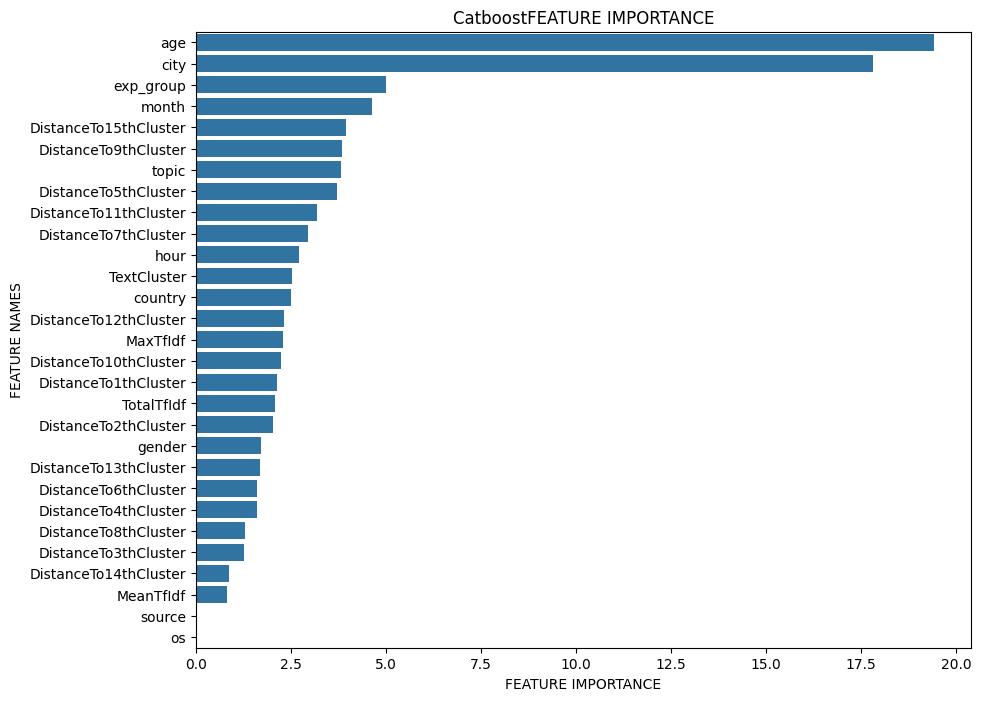

In [27]:
## feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost_optuna.feature_importances_,X_train.columns,'Catboost')